## Intro

![alt text](../imgs/trump_task_force.jpg)
- Given the controversy over the Trump administration's handling of the pandemic, I thought it would be interesting to apply some of the basic NLP techniques I've been learning recently to explore this timely, readily available body of text.
- Dates range of the press conferences. From 2020-02-26 to 2020-04-27
- The end to end analysis can be found in this notebook (link)
- Header: Exploring the tone/sentiment/emotion of task force briefing transcripts
 - Exploring sentiment, emotion and topics in the daily task force breifing transcripts

### Scraping & Cleaning Briefing Transcripts
The daily briefing transcripts are actually available on [rev.com](https://www.rev.com) in formatted `.txt` files, but I wanted to practice using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) for web scraping as part of this project. The scraped transcripts are included [here](https://github.com/brendoncampbell/corona-briefing-tones/blob/master/data/all_briefings.csv), and [`scrape_briefings.py`](https://github.com/brendoncampbell/corona-briefing-tones/blob/master/src/scrape_briefings.py) can be ran to rescrape them.

After reading in this relatively clean CSV, we have a simple dataframe containing chronological paragraphs of speech `text` along with the corersponding `date`, `timestamp` and `speaker`:

In [1]:
import pandas as pd
import altair as alt

In [2]:
alt.renderers.enable('png')
#alt.renderers.enable('mimetype')

RendererRegistry.enable('png')

In [3]:
# import scraped csv to pandas df
briefings_df = pd.read_csv('../data/all_briefings.csv')
briefings_df

,date,timestamp,speaker,text
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ..."
...,...,...,...,...
9677,2020-04-27,01:01:23,Reporters,[crosstalk 00:13:23].
9678,2020-04-27,01:01:24,Donald Trump,"Let’s do one more. Please, in the back."
9679,2020-04-27,01:01:26,Speaker 16,If an American president loses more Americans ...
9680,2020-04-27,01:01:36,Donald Trump,"So yeah, we’ve lost a lot of people, but if yo..."


### Null Values
Checking for null values, we can see there are actually only 3 missing `text` values in the nearly 10,000 rows. 

In [4]:
briefings_df[briefings_df['text'].isnull()]

,date,timestamp,speaker,text
7217,2020-04-13,16:03,Donald Trump,NaN
8339,2020-04-19,23:03,Andrew Cuomo,NaN
9181,2020-04-22,01:15:03,Dr. Birx,NaN


A quick look at the full transcripts and video recordings confirms these correspond to the speaker interjecting, being cut off, or uttering something inaudible. For the purpose of this analysis let's simply drop these:

In [5]:
briefings_df = briefings_df.dropna(subset=['text']).reset_index(drop=True)

### Cleaning Up Speaker Names

Checking the names of the most frequent speakers, we see a few opportunities to clean-up this column before starting any analysis

1. Unnamed speakers identified by a number (e.g. `Speaker 12`) are reset for each briefing, and therefore don't map to the same person.
2. Donald Trump and some of the other key task force members are referenced by multiple names (`Dr. Birx`, `Dr. Deborah Birx`)
3. There are a handful of male reporters (John, Jeff, Jim, Peter, and Steve) frequently called upon by their first name

In [6]:
# how many paragraphs of text for the top speakers?
briefings_df['speaker'].value_counts()[:40]

Donald Trump              4013
Mike Pence                 751
Dr. Birx                   244
Dr. Fauci                  237
John                       161
Deborah Birx               101
Dr. Deborah Birx            94
Admiral Giroir              94
Speaker 8                   93
Speaker 7                   92
Speaker 5                   88
Steve Mnuchin               84
Speaker 11                  82
Speaker 12                  82
Speaker 22                  79
Speaker 3                   78
Speaker 10                  76
Speaker 9                   76
Speaker 4                   73
Speaker 6                   73
Speaker 13                  72
Speaker 14                  68
Speaker 2                   65
Speaker 19                  64
Speaker 15                  61
Speaker 16                  60
Mike Pompeo                 59
Reporter                    58
Jeff                        56
Vice President Pence        53
Speaker 23                  52
Speaker 18                  52
Speaker 

Let's clean-up and consolidte these so we have consistent naming of speakers:

In [7]:
# replace speaker names using basic regex
briefings_df['speaker'].replace(regex={r'.*Trump.*': 'Donald Trump', 
                                       r'.*Pence.*': 'Mike Pence',
                                       r'.*Fauci.*': 'Dr. Anthony Fauci',
                                       r'.*Birx.*': 'Dr. Deborah Birx',
                                       r'.*Berks.*': 'Dr. Deborah Birx',
                                       r'.*Pompeo.*': 'Mike Pompeo',
                                       r'.*Report.*': 'Unnamed (Reporter)',
                                       r'.*Audience Member.*': 'Unnamed',
                                       r'.*Speaker .*': 'Unnamed', 
                                       r'.*Jeff\Z': 'Jeff (Reporter)',
                                       r'.*John\Z': 'John (Reporter)',
                                       r'.*Peter\Z': 'Peter (Reporter)',
                                       r'.*Jim\Z': 'Jim (Reporter)',
                                       r'.*Steve\Z': 'Steve (Reporter)',
                                       r'.*Pete\Z': 'Pete Gaynor',
                                       r'.*Novarro.*': 'Peter Navarro',
                                       r'.*Surgeon General.*': 'Jerome Adams',
                                       r'.*Giroir.*': 'Brett Giroir',
                                       r'.*Polowczyk.*': 'John Polowczyk',
                                       r'.*Verma.*': 'Seema Verma',
                                       r'.*Azar.*': 'Alex Azar',
                                       r'.*Hahn.*': 'Dr. Steven Hahn',
                                       r'.*Mnuchin.*': 'Steve Mnuchin'},
                                inplace = True)

briefings_df['speaker'].value_counts()[:20]

Donald Trump          4091
Unnamed               2038
Mike Pence             849
Dr. Deborah Birx       491
Dr. Anthony Fauci      317
Unnamed (Reporter)     215
John (Reporter)        162
Steve Mnuchin          136
Brett Giroir           100
Mike Pompeo             81
Dr. Steven Hahn         64
Alex Azar               63
Seema Verma             56
Jeff (Reporter)         56
John Polowczyk          49
Jerome Adams            48
Jim (Reporter)          47
Steve (Reporter)        46
Peter Navarro           35
Peter (Reporter)        33
Name: speaker, dtype: int64

## Preprocessing

In [8]:
import spacy
from pandarallel import pandarallel
import re

In [9]:
# Load English spacy model and stop words
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

In [10]:
# function for preprocessing each paragraph of transcript text
def preprocess(text, 
               min_token_len = 2, 
               irrelevant_pos = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE']): 
    """
    Carry out preprocessing of the text and return a preprocessed list of strings. 
    
    Parameters
    -------------
    text : (str) 
        the text to be preprocessed
    min_token_len : (int) 
        min_token_length required
    irrelevant_pos : (list) 
        a list of irrelevant pos tags
    
    Returns
    -------------
    (list) the preprocessed text as a list of strings
    """
    
    # convert input string to lowercase
    text = text.lower()

    # remove multiple whitespace characters
    text = re.sub(r'\s+',' ', text)
    
    # tokenize with spacy, exluding stop words, short tokens, 
    # irrelevant POS, emails, urls, and strings containing 
    # non-alphanumeric chars
    
    doc = nlp(text)
    token_list = []
    for token in doc:
        if token.is_stop == False and len(token.text)>=min_token_len \
            and token.pos_ not in irrelevant_pos and token.like_email == False \
            and token.like_url == False and token.text.isalnum():
            token_list.append(token.lemma_)
        
    return token_list

#### Pre-process the raw text prior to topic modelling:

In [11]:
# parallelize preprocessing to reduce execution time
pandarallel.initialize(verbose=False)

# apply preprocessor to each row of text
briefings_df['pp_text'] = briefings_df.text.parallel_apply(preprocess)

In [12]:
briefings_df['pp_text'].head()

0    [thank, thank, begin, like, extend, deep, cond...
1    [lot, people, think, turn, good, thing, number...
2    [total, 15, take, japan, hear, american, citiz...
3    [china, know, start, speak, president, xi, gre...
4    [bring, specialist, regarded, specialist, tomo...
Name: pp_text, dtype: object

### Emotion Analysis

Now that we have a nice clean dataframe to work with, it's time to move on to analysis. Rather than using the popular [TextBlob](https://textblob.readthedocs.io/en/dev/) or [Vader](https://github.com/cjhutto/vaderSentiment) packages commonly used for sentiment analysis, I thought it would be interesting to also explore the emotional tone of briefing texts.

Let's see what we can uncover using the NRC Word-Emotion Association Lexicon, [EmoLex](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm). In addition to 'positive' and 'negative', we get word associations for eight basic emotion categories.

In [13]:
# read in raw emotion lexicon
filepath = "../NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=1, sep='\t')

# pivot df so we have one row per word, one column per emotion
emolex_df = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_df.columns.name = 'index'

# filter out words without scores, as well as those with more than 7 scores
emolex_df = emolex_df[emolex_df.sum(axis=1)>0].reset_index(drop=True)
emolex_df = emolex_df[emolex_df.sum(axis=1)<7].reset_index(drop=True)
emolex_df

index,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,abacus,0,0,0,0,0,0,0,0,0,1
1,abandon,0,0,0,1,0,1,0,1,0,0
2,abandoned,1,0,0,1,0,1,0,1,0,0
3,abandonment,1,0,0,1,0,1,0,1,1,0
4,abba,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6437,zany,0,0,0,0,0,0,0,0,1,0
6438,zeal,0,1,0,0,1,0,1,0,1,1
6439,zealous,0,0,0,0,1,0,1,0,0,1
6440,zest,0,1,0,0,1,0,1,0,0,1


We can now use this lexicon to easily retrieve associations for the words in a single briefing `text`:

In [14]:
print(briefings_df.text[504])

Thank you, Mr. President. We just completed today’s meeting of the White House coronavirus task force. We had the opportunity to brief the President today on a broad range of issues. Once again, because of the unprecedented action that President Trump took in January, suspending all travel from China, establishing travel advisories for portions of South Korea and Italy, establishing screening of all direct flights, all passengers from all airports, Italy and South Korea… we have bought a considerable amount of time, according to all the health experts, to deal with the coronavirus here in the United States.


In [16]:
paragraph_words = briefings_df.pp_text[504]
print(paragraph_words)

['thank', 'mr', 'president', 'complete', 'today', 'meeting', 'white', 'house', 'coronavirus', 'task', 'force', 'opportunity', 'brief', 'president', 'today', 'broad', 'range', 'issue', 'unprecedented', 'action', 'president', 'trump', 'take', 'january', 'suspend', 'travel', 'china', 'establish', 'travel', 'advisory', 'portion', 'south', 'korea', 'italy', 'establish', 'screening', 'direct', 'flight', 'passenger', 'airport', 'italy', 'south', 'korea', 'buy', 'considerable', 'time', 'accord', 'health', 'expert', 'deal', 'coronavirus', 'united', 'states']


In [17]:
emolex_df[pd.DataFrame(emolex_df.word.tolist()).isin(paragraph_words).any(1)]

index,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
55,accord,0,0,0,0,0,0,1,0,0,1
80,action,0,0,0,0,0,0,1,0,0,0
174,airport,0,1,0,0,0,0,0,0,0,0
1182,considerable,0,0,0,0,0,0,1,0,0,0
1460,deal,0,1,0,0,1,0,1,0,1,1
2098,establish,0,0,0,0,0,0,0,0,0,1
2184,expert,0,0,0,0,0,0,1,0,0,1
2392,force,1,0,0,1,0,1,0,0,0,0
4088,opportunity,0,1,0,0,0,0,1,0,0,0
4209,passenger,0,1,0,0,0,0,0,0,0,0


Following this approach, let's calculate and store aggregate emotion scores for each briefing paragraph:

In [18]:
# create empty df to store aggregated emotion calcs
data = pd.DataFrame([])

for tokens in briefings_df['pp_text']:
    paragraph_emos = emolex_df[pd.DataFrame(emolex_df.word.tolist()).isin(tokens).any(1)].mean()
    data = data.append(paragraph_emos, ignore_index=True)
    
# combine aggregated emotion scores with transcript df
briefings_df = briefings_df.join(data)

# drop empty 'word' column, fill NaNs with zero
briefings_df = briefings_df.drop(columns=['word'])
briefings_df = briefings_df.fillna(0)

briefings_df.head()

,date,timestamp,speaker,text,pp_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...,"[thank, thank, begin, like, extend, deep, cond...",0.428571,0.071429,0.214286,0.428571,0.142857,0.571429,0.285714,0.428571,0.142857,0.071429
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...,"[lot, people, think, turn, good, thing, number...",0.111111,0.444444,0.111111,0.333333,0.111111,0.333333,0.444444,0.222222,0.111111,0.333333
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...,"[total, 15, take, japan, hear, american, citiz...",0.187500,0.312500,0.062500,0.250000,0.187500,0.250000,0.437500,0.250000,0.250000,0.187500
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...,"[china, know, start, speak, president, xi, gre...",0.083333,0.250000,0.000000,0.083333,0.250000,0.250000,0.666667,0.000000,0.083333,0.500000
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ...","[bring, specialist, regarded, specialist, tomo...",0.272727,0.090909,0.181818,0.545455,0.000000,0.636364,0.181818,0.454545,0.272727,0.090909


# Topic Modelling

In [19]:
import gensim.corpora as corpora
from gensim import models
import pyLDAvis.gensim

#### Create dictionary and document-term co-occurence matrix
- here we're using the gensim topic modelling package

In [20]:
# build dictionary
corpus = briefings_df['pp_text'].tolist()
dictionary = corpora.Dictionary(corpus)
len(dictionary)

7911

In [21]:
# build dictionary and filter extremes, removing tokens that appear in
# either: fewer than 5 paragraphs, or in more than 10% of all paragraphs
dictionary = corpora.Dictionary(corpus)
dictionary.filter_extremes(no_below = 10, no_above = 0.1)
len(dictionary)

2037

In [22]:
# define words to be manually removed and retrieve their indexes
remove_words = ['crosstalk', 'question', 'inaudible', 'mr', 'sir', 'dr']
del_indexes = [k for k,v in dictionary.items() if v in remove_words]

# remove unwanted word ids from the dictionary
dictionary.filter_tokens(bad_ids=del_indexes)

In [23]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

#### Build and visualize the topic model:

In [24]:
lda_model = models.LdaModel(corpus=doc_term_matrix,
                      id2word=dictionary,
                      num_topics=6,
                      passes=20,
                      random_state=123)

In [25]:
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, sort_topics=False)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.054672 -0.289469       1        1  13.044097
1      0.222367  0.005122       2        1  19.765024
2     -0.123680  0.099529       3        1  22.420975
3     -0.019933  0.097242       4        1  15.147667
4      0.208270  0.040015       5        1  16.646456
5     -0.232351  0.047560       6        1  12.975780, topic_info=            Term         Freq        Total Category  logprob  loglift
434         test  1746.000000  1746.000000  Default  30.0000  30.0000
1012     testing  1121.000000  1121.000000  Default  29.0000  29.0000
295          new  1428.000000  1428.000000  Default  28.0000  28.0000
176     governor  1473.000000  1473.000000  Default  27.0000  27.0000
322     business   604.000000   604.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1602  ventilator   160.672516   865.495728   Topic6  -4.8906   0.3582
202       effort   130.992279   280.172791   Topic6  -5.0948   1.2818
190         vice   125.731140   369.036896   Topic6  -5.1358   0.9653
246         meet   123.211304   233.880508   Topic6  -5.1560   1.4012
101          day   124.649330  1225.462036   Topic6  -5.1444  -0.2435

[389 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1850      4  0.997117   abbott
868       4  0.888849  ability
868       6  0.103055  ability
232       1  0.126517     able
232       3  0.069584     able
...     ...       ...      ...
560       2  0.386529      yes
560       4  0.007293      yes
560       5  0.608966      yes
545       3  0.028976     york
545       5  0.969940     york

[694 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

After experimenting with different numbers of topics and filtering out extreme tokens, we see pretty good results with the following 6 topics being identified:
Note the interactive output from pyLDAvis package.

In [26]:
topic_labels = {0:'Economy',
                1:'International',
                2:'Policy & Guidelines',
                3:'Testing',
                4:'Ventilators & NY Outbreak',
                5:'PPE'
               }

### Use the topic model to predict a topic for each text:

In [27]:
def get_most_prob_topic(unseen_document, model = lda_model):
    """
    Given an unseen_document, and a trained LDA model, this function
    finds the most likely topic (topic with the highest probability) from the 
    topic distribution of the unseen document and returns the best topic
    
    Parameters
    ------------
    unseen_document : (str) 
        the document to be labeled with a topic
    model : (gensim ldamodel) 
        the trained LDA model
    
    Returns: 
    -------------
        (str) the most likely topic label
    
    Examples:
    ----------
    >> get_most_prob_topic("We're building so so so many ventilators.", 
                            model = lda)
    Ventilators
    """
    
    # preprocess unseen text and obtain bow vector
    unseen_doc_pp = preprocess(unseen_document)
    bow_vector = dictionary.doc2bow(unseen_doc_pp)
    
    # calculate topic scores for unseen text
    scores_df = pd.DataFrame(lda_model[bow_vector], columns =['topic', 'score']) 
    
    # find topic name of max score
    topic_name = topic_labels[scores_df.loc[scores_df['score'].idxmax(), 'topic']]
    best_score = scores_df['score'].max()
    
    return topic_name, best_score;

In [28]:
# create empty lists to store prediction strings
predictions = []
scores = []

# call function for each unseen text, appending predictions to list
for text in briefings_df['pp_text'].tolist():
    # we'll only predict a topic for texts where there are 4 or more tokens
    if len(text) > 4:
        topic, value = get_most_prob_topic(' '.join(text))
        predictions.append(topic)
        scores.append(value)
    else:
        predictions.append(None)
        scores.append(None)

# add prediction values to main df
briefings_df['topic_pred'] = predictions
briefings_df['topic_score'] = scores

In [29]:
briefings_df

,date,timestamp,speaker,text,pp_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,topic_pred,topic_score
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...,"[thank, thank, begin, like, extend, deep, cond...",0.428571,0.071429,0.214286,0.428571,0.142857,0.571429,0.285714,0.428571,0.142857,0.071429,International,0.544385
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...,"[lot, people, think, turn, good, thing, number...",0.111111,0.444444,0.111111,0.333333,0.111111,0.333333,0.444444,0.222222,0.111111,0.333333,Policy & Guidelines,0.573967
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...,"[total, 15, take, japan, hear, american, citiz...",0.187500,0.312500,0.062500,0.250000,0.187500,0.250000,0.437500,0.250000,0.250000,0.187500,International,0.337955
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...,"[china, know, start, speak, president, xi, gre...",0.083333,0.250000,0.000000,0.083333,0.250000,0.250000,0.666667,0.000000,0.083333,0.500000,International,0.599763
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ...","[bring, specialist, regarded, specialist, tomo...",0.272727,0.090909,0.181818,0.545455,0.000000,0.636364,0.181818,0.454545,0.272727,0.090909,Testing,0.322573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9674,2020-04-27,01:01:23,Unnamed (Reporter),[crosstalk 00:13:23].,[crosstalk],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,None,NaN
9675,2020-04-27,01:01:24,Donald Trump,"Let’s do one more. Please, in the back.",[let],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,None,NaN
9676,2020-04-27,01:01:26,Unnamed,If an American president loses more Americans ...,"[american, president, lose, americans, course,...",0.400000,0.200000,0.200000,0.600000,0.000000,0.600000,0.400000,0.400000,0.200000,0.400000,Policy & Guidelines,0.586939
9677,2020-04-27,01:01:36,Donald Trump,"So yeah, we’ve lost a lot of people, but if yo...","[yeah, lose, lot, people, look, original, proj...",0.250000,0.125000,0.125000,0.250000,0.125000,0.500000,0.500000,0.125000,0.250000,0.125000,International,0.455969


In [30]:
# save scored df to csv
briefings_df.to_csv("../data/scored_briefings.csv",index=False)

In [31]:
briefings_df.describe()

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,topic_score
count,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,7197.000000
mean,0.061721,0.189397,0.036887,0.122081,0.103303,0.184094,0.459510,0.083889,0.072130,0.319986,0.607561
std,0.137658,0.234470,0.111955,0.187975,0.182764,0.242978,0.340606,0.158906,0.149078,0.297559,0.168801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.477991
50%,0.000000,0.133333,0.000000,0.000000,0.000000,0.100000,0.500000,0.000000,0.000000,0.312500,0.586208
75%,0.083333,0.333333,0.000000,0.200000,0.166667,0.300000,0.692308,0.125000,0.105263,0.500000,0.731230
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.986487


## Analysis & Visualization

As anyone following along might expect, we see that on average the briefings tended to strike a more positive than negative tone.


Show plot for the emotions? "When I started out I suspected we might see some clearer trends over time."
Note on time series analysis vs ordinal by briefing. Given the imprecise emotion scoring

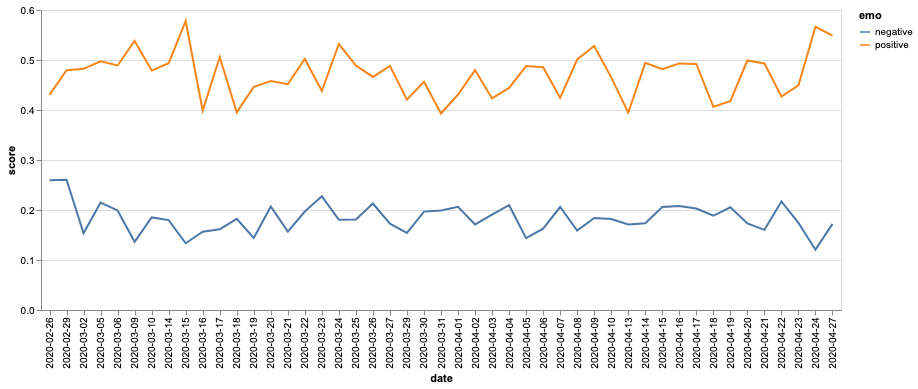

In [32]:
# ALL SPEAKERS, TRY TO FACET BY SPEAKERS?

briefings_by_date = briefings_df.groupby(['date']).mean().reset_index()
sentiment_by_date = briefings_by_date[['positive', 'negative', 'date']]
sentiment_by_date = sentiment_by_date.melt(['date'], var_name='emo', value_name='score')


alt.Chart(sentiment_by_date).mark_line().encode(
    x='date:O',
    y='score:Q',
    color='emo:N'
).properties(width = 800)

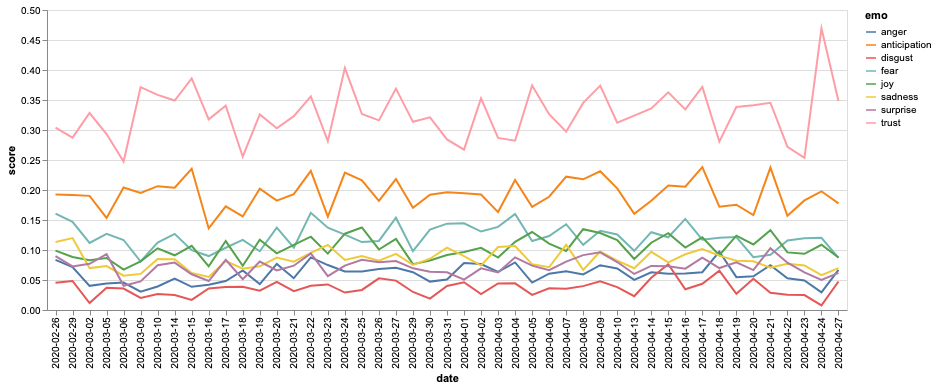

In [33]:
emotion_by_date = briefings_by_date.drop(columns=['topic_score', 'positive', 'negative'])
emotion_by_date = emotion_by_date.melt(['date'], var_name='emo', value_name='score')
emotion_by_date

alt.Chart(emotion_by_date).mark_line().encode(
    x='date:O',
    y='score:Q',
    color='emo:N'
).properties(width = 800)

In [34]:
# strong fear and sadness scores on 2020-04-16
briefings_by_date.sort_values(by='fear', ascending=False).head(5)

,date,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,topic_score
15,2020-03-22,0.087568,0.231835,0.040246,0.162040,0.122133,0.196973,0.501910,0.095169,0.094293,0.355948,0.592209
0,2020-02-26,0.083491,0.192683,0.045268,0.160710,0.099012,0.259590,0.430136,0.113447,0.089720,0.304056,0.602664
27,2020-04-04,0.079283,0.216782,0.044421,0.160031,0.113695,0.209564,0.444201,0.106694,0.087797,0.282138,0.622099
20,2020-03-27,0.070379,0.218151,0.048977,0.153848,0.118637,0.172740,0.487975,0.093499,0.081705,0.368970,0.566977
37,2020-04-16,0.060887,0.205436,0.034602,0.151805,0.104081,0.208135,0.493181,0.092934,0.068970,0.334371,0.589919


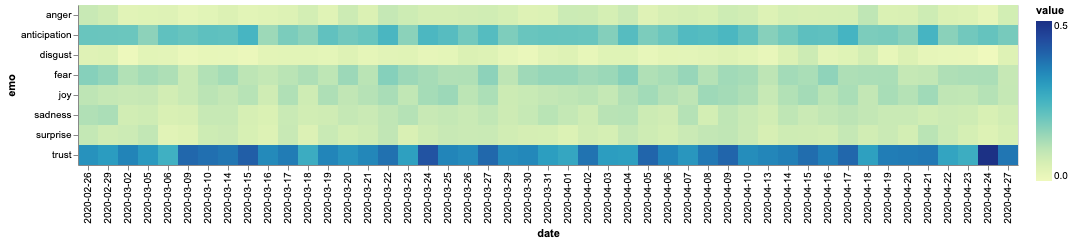

In [35]:
speaker_feels = briefings_df
speaker_feels = speaker_feels.drop(columns=['topic_score', 'positive', 'negative'])
speaker_feels_by_date = speaker_feels.groupby(['date']).mean().reset_index()
speaker_feels_by_date = speaker_feels_by_date.melt('date', var_name='emo', value_name='value')


alt.Chart(speaker_feels_by_date).mark_rect().encode(
    x='date:O',
    y='emo:N',
    color='value:Q'
)

In [36]:
# plot heatmap by date for a speaker

def emo_date_heatmap(speaker):
    speaker_feels = briefings_df[briefings_df['speaker']==speaker]
    speaker_feels = speaker_feels.drop(columns=['topic_score', 'positive', 'negative'])
    speaker_feels_by_date = speaker_feels.groupby(['date']).mean().reset_index()
    speaker_feels_by_date = speaker_feels_by_date.melt('date', var_name='emo', value_name='value')


    plot = alt.Chart(speaker_feels_by_date).mark_rect().encode(
        x='date:O',
        y='emo:N',
        color='value:Q'
    ).properties(title = speaker)
    
    return plot

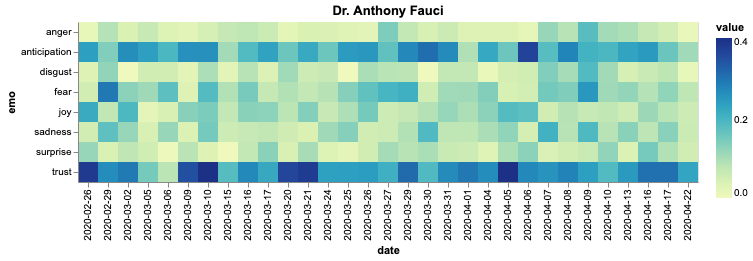

In [37]:
emo_date_heatmap('Dr. Anthony Fauci')

In [ ]:
emo_date_heatmap('Donald Trump')

### Topics:

In [ ]:
topics_by_date = briefings_df.groupby(['topic_pred', 'date']).mean().reset_index()
topics_by_date = topics_by_date.melt(['topic_pred', 'date'], var_name='emo', value_name='score')

alt.Chart(topics_by_date[topics_by_date['emo'] == 'positive']).mark_rect().encode(
    alt.X('date:O'),
    alt.Y('topic_pred:O'),
    alt.Color('score:Q', scale=alt.Scale(scheme='blues'))
)

In [ ]:
trump_briefings_df = briefings_df[briefings_df['speaker'] == 'Donald Trump']
trump_topics_by_date = trump_briefings_df.groupby(['topic_pred', 'date']).mean().reset_index()
trump_topics_by_date = trump_topics_by_date.melt(['topic_pred', 'date'], var_name='emo', value_name='score')

alt.Chart(trump_topics_by_date[trump_topics_by_date['emo'] == 'positive']).mark_rect().encode(
    alt.X('date:O'),
    alt.Y('topic_pred:O'),
    alt.Color('score:Q', scale=alt.Scale(scheme='blues'))
)

### Scratchpad for other ideas:

In [ ]:
# query for specific terms rather than topics
# chloroquine, ventilator, remdesivir etc

briefings_df[briefings_df['text'].str.contains("China")][100:110]

In [ ]:
for i in briefings_df.sort_values(by='topic_score', ascending=False)['text'].head(5):
    print(i)
    print()

- Monochrome heatmap
- Compare line plot to vader
- revisit emotion calcs: index 2377 "That's the game" is a good one to check out.
- calculate emotion scores for an entire session overall
- token/lemma prior to emotion lexicon???
- parallelize/`apply` the emotion evaluation similar to the preprocessing in topic modelling


> how sentiments/topics compare between speaker

> how sentiments/topics have evolved over the pandemic.   

> SHOW MOST FEARFUL/ANGRY PORTIONS

> filter out the topic predictions below a certain strength ?

> Specific dates: April 13th, total authority. 

> Reporters tones

In [ ]:


# https://www.rev.com/blog/transcript-tag/andrew-cuomo-transcripts/page/5
    
# https://www.rev.com/blog/transcript-tag/canada-coronavirus-briefing-transcripts/page/3

In [ ]:
briefings_df[briefings_df['timestamp'] == '01:19:06']